# Lens modeling of DESIJ1101-0602 with `lenstronomy`

**Author:** Jannatul Ferdous, Fahim Rajit Hossain

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import of standard python libraries
!pip install emcee
import emcee
!pip install corner
import corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.7 MB/s eta 0:00:00


In [3]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.2-py3-none-any.whl size=1086826 sha256=22d4264a671ec0019342cf920211b1fbd8fe81bbeca1d0776363fd6253e2c827
  Stored in directory: /root/.cache/pip/wheels/1c/62/fa/1c6f5bd9f9e9e37978c5ef811810e69118ea87f2a1cd0b946d
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15728 sha256=00585a1667922e3cbf888bf9940e43c03f880033e42745f7f27d8401ccfe9b7f
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea548b8e

In [4]:
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

In [5]:
# load HDF5 file

with h5py.File('/content/drive/MyDrive/BDLensing/DESIJ1101-0602_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

# load HDF5 psf file using h5py
with h5py.File('/content/drive/MyDrive/BDLensing/psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

In [6]:
image_size = kwargs_data['image_data'].shape
print(image_size)

(180, 180)


<ipython-input-7-3fa448f29b79>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',


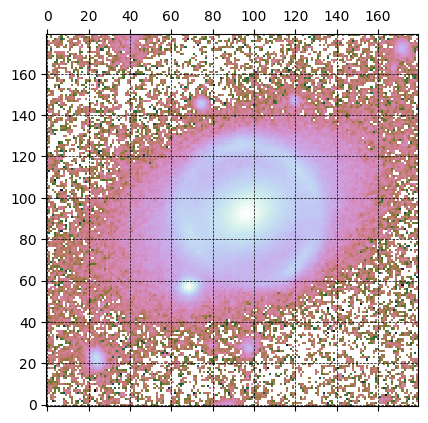

In [7]:
plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',
            cmap='cubehelix')
plt.grid(True, which='both', linewidth=0.5, linestyle = '--', color='black')

plt.xticks(np.arange(0, 180, 20))
plt.yticks(np.arange(0, 180, 20))

plt.show()

# Creating Likelihood Mask

A likelihood mask is a tool used in statistical analysis, particularly in Bayesian statistics, to identify data points that have a strong influence on the final results of a model. It is a binary mask that identifies which data points in the model contribute to the likelihood function, and which data points do not.

In practical terms, a likelihood mask can be created by setting a threshold for the quality of the data, such as the signal-to-noise ratio or the uncertainty in the measurements. Data points that do not meet this threshold can be masked out, effectively removing them from the analysis. This can help to improve the accuracy and precision of the model by reducing the impact of noisy or unreliable data.

Likelihood masks can also be used to exclude regions of the data that are known to be problematic, such as areas affected by foreground contamination, instrumental effects, or other sources of systematic error. By excluding these regions from the analysis, the likelihood mask can help to improve the robustness and reliability of the model.

In [8]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle,
                     ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 6 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

# mask_outer_2 = mask_util.mask_center_2d(
#     lens_center_ra,
#     lens_center_dec,
#     r2,
#     util.image2array(x_coords),
#     util.image2array(y_coords),)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.9,
    lens_center_dec - 2.6,
    0.7,
    0.7,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.34,
    lens_center_dec + 4.6,
    0.3,
    0.3,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3,
    lens_center_dec + 4.3,
    0.35,
    0.35,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5 ,
    lens_center_dec - 4.9,
    0.45,
    0.45,
    0,
)
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1 ,
    lens_center_dec - 4.9,
    0.4,
    0.4,
    0,
)

mask_1 = (1 - mask_outer_1) * (1 - mask_ext_1)
mask_2 = (1 - mask_ext_2) * (1 - mask_ext_3)
mask_3 = (1 - mask_ext_4) *  (1 - mask_ext_5)
mask1 = mask_1 * mask_2 *  mask_3
mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0

mask_img = mask1.reshape(num_pix, num_pix)

# Applying the Mask

<ipython-input-9-b9efef47b1dc>:3: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(kwargs_data['image_data']),
<ipython-input-9-b9efef47b1dc>:16: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-9-b9efef47b1dc>:16: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


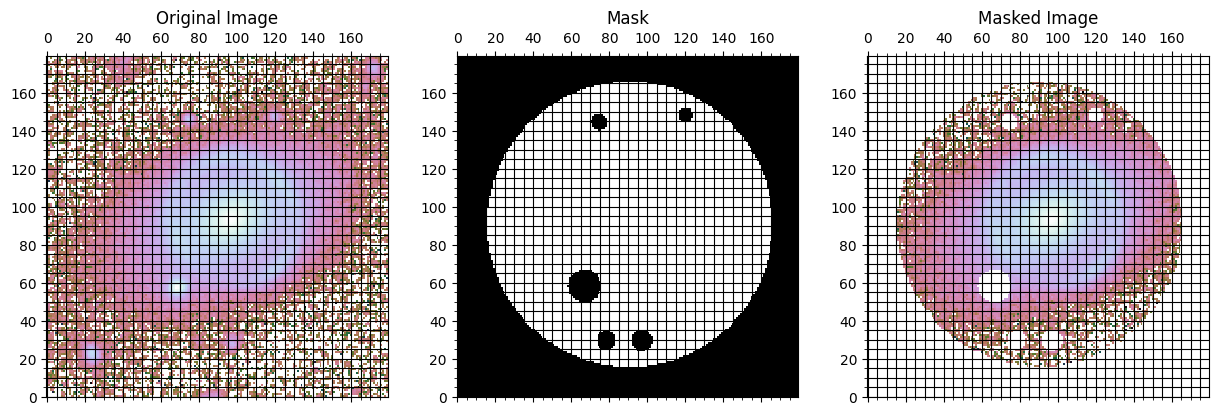

In [9]:
# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(kwargs_data['image_data']),
            origin='lower', cmap='cubehelix')
ax1.grid(which='both', color='black')
ax1.minorticks_on()
ax1.grid(which='minor', color='black')
ax1.title.set_text('Original Image')
ax2.matshow(mask_img, origin='lower', cmap='cubehelix')
ax2.grid(which='both', color='black')
ax2.minorticks_on()
ax2.grid(which='minor', color='black')
ax2.title.set_text('Mask')
ax2.title.set_text('Mask')

image = np.log10(kwargs_data["image_data"] * mask_img)

ax3.matshow(image, origin='lower', cmap='cubehelix')
ax3.grid(which='both', color='black')
ax3.minorticks_on()
ax3.grid(which='minor', color='black')
ax3.title.set_text('Masked Image')
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [10]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE"]

## Lens galaxy's mass model

In [11]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# Setting EPL Parameters

fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 1.3, 'gamma': 2., 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})


# Setting SHEAR Parameters
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]


## Lens galaxy's light model

In [12]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# Sersic profile
fixed_lens_light.append({})

kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0,
                     'e2': 0,'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05,
                    'e2': 0.05,'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
                 'n_sersic': .5 ,'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10,
                'n_sersic': 5.,'center_x': 10, 'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [kwargs_lens_light_init,
                     kwargs_lens_light_sigma,
                     fixed_lens_light,
                     kwargs_lower_lens_light,
                     kwargs_upper_lens_light]


## Source galaxy's light model

In [13]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0,
                  'e2': 0,'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05,
                            'e2': 0.05,'center_x': 0.2, 'center_y': 0.2,
                            'amp': 10})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001,
            'n_sersic': .5, 'center_x': -10, 'center_y': -10,'amp': 0})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10,
        'n_sersic': 5.,  'center_x': 10, 'center_y': 10, 'amp': 100})


# SHAPELETS profile

fixed_source.append({'n_max': 6})
kwargs_source_init.append({'beta': 0.05, 'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'beta': 0.1, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.001, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'beta': 0.2, 'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]

source_params = [kwargs_source_init,
                 kwargs_source_sigma,
                 fixed_source,
                 kwargs_lower_source,
                 kwargs_upper_source]

## combining all the above specification in the `kwargs_params` dictionary

In [14]:
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      "joint_source_with_source": joint_source_with_source}

#### Numerical settings

Applied Mask Likelihood here

In [15]:
kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list':  [mask_img]}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

#### Combining all the information to be sent to lenstronomy

In [16]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data,
                    kwargs_psf,
                    kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'}

## Here the model fiting is done

In [49]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
    kwargs_constraints, kwargs_likelihood, kwargs_params,
    mpi=False,
    verbose=True)

fitting_kwargs_list = [["PSO", {"sigma_scale": 1.0,
                                "n_particles": 500,
                                "n_iterations": 100}]]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.8667544826619314 reduced X^2 of best position
-7423.318766758111 log likelihood
17129 effective number of data points
[{'theta_E': 2.6577680833397044, 'gamma': 1.6086443754833157, 'e1': 0.14375540622885222, 'e2': -0.15556430332965732, 'center_x': -0.4900163588968056, 'center_y': 0.20152753605526286}, {'gamma1': 0.07824543798573118, 'gamma2': -0.06938689780847904, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 5.655205370410237, 'n_sersic': 1.0, 'e1': -0.08515246143264929, 'e2': -0.10675410936875317, 'center_x': -0.46085249469856004, 'center_y': 0.1471697101061184}, {'amp': 1, 'n_max': 6, 'beta': 0.10377131866102154, 'center_x': -0.46085249469856004, 'center_y': 0.1471697101061184}] source result
[{'amp': 1, 'R_sersic': 1.5295866595768872, 'n_sersic': 2.1353963917324186, 'e1': 0.14375540622885222, 'e2': -0.15556430332965732, 'center_x': -0.4900163588968056, 'center_y': 0.201527536055262

## Visualizing the fitted model with `PSO`

In [50]:
print(kwargs_result)

{'kwargs_lens': [{'theta_E': 2.6577680833397044, 'gamma': 1.6086443754833157, 'e1': 0.14375540622885222, 'e2': -0.15556430332965732, 'center_x': -0.4900163588968056, 'center_y': 0.20152753605526286}, {'gamma1': 0.07824543798573118, 'gamma2': -0.06938689780847904, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 5.655205370410237, 'n_sersic': 1.0, 'e1': -0.08515246143264929, 'e2': -0.10675410936875317, 'center_x': -0.46085249469856004, 'center_y': 0.1471697101061184}, {'amp': 1, 'n_max': 6, 'beta': 0.10377131866102154, 'center_x': -0.46085249469856004, 'center_y': 0.1471697101061184}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.5295866595768872, 'n_sersic': 2.1353963917324186, 'e1': 0.14375540622885222, 'e2': -0.15556430332965732, 'center_x': -0.4900163588968056, 'center_y': 0.20152753605526286}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


-0.8644330441639723 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8644330441639725


<ipython-input-51-720a867a37ae>:30: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


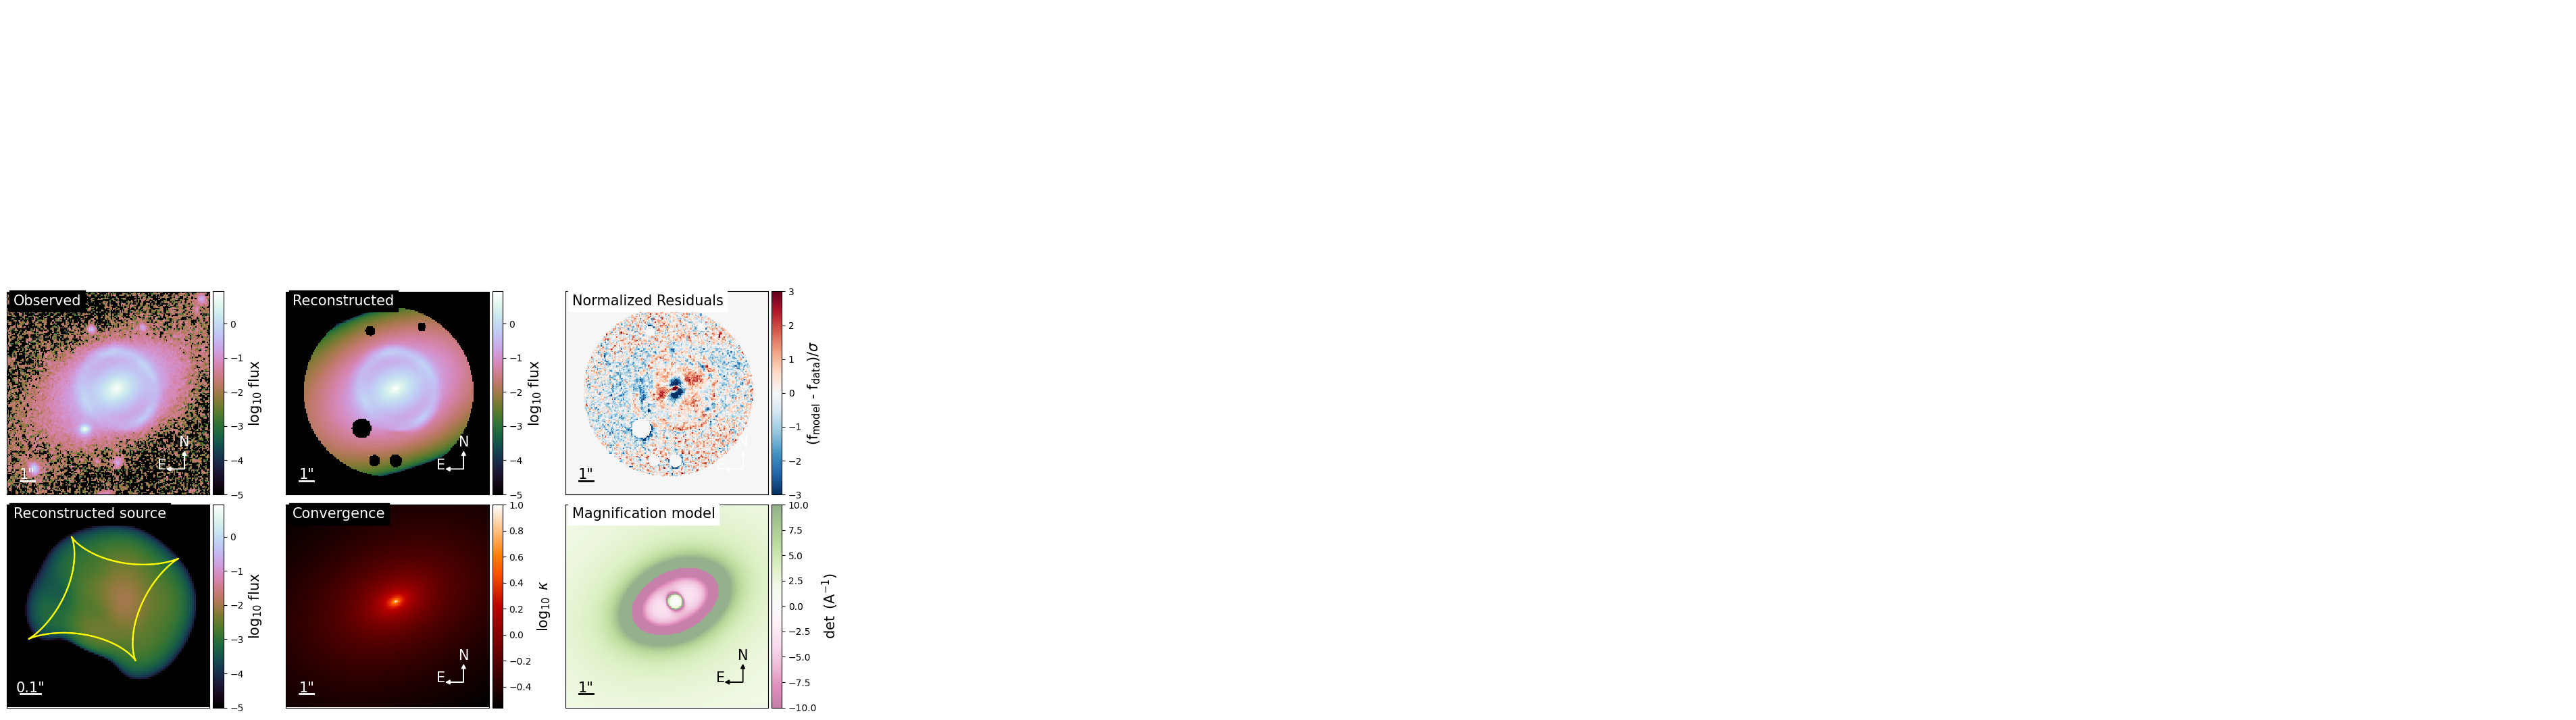

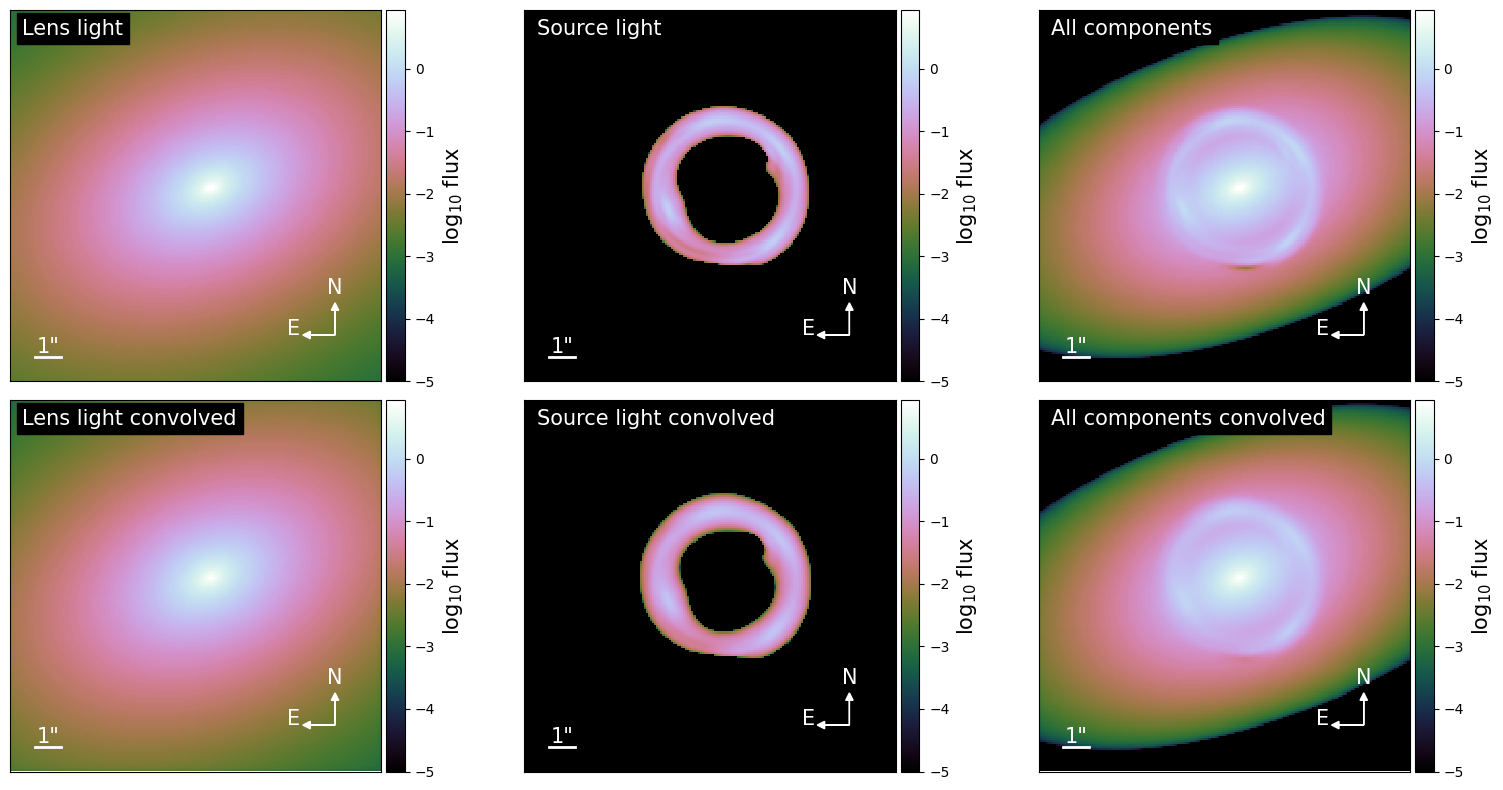

In [51]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2],
                                    v_min=-3,
                                    v_max=3,
                                    cmap="RdBu_r",
                                   )
model_plot.source_plot(ax=axes[1, 0],
                       deltaPix_source=0.01,
                       numPix=100,
                       with_caustics=True,
                      )
model_plot.convergence_plot(ax=axes[1, 1],
                            v_max=1,
                            cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2],
                              cmap="PiYG",
                             )
f.tight_layout()
f.subplots_adjust(left=None,
                  bottom=None,
                  right=None,
                  top=None,
                  wspace=0.0,
                  hspace=0.05,
                 )
plt.show()

f, axes = plt.subplots(2,
                       3,
                       figsize=(16, 8),
                       sharex=False,
                       sharey=False,
                      )

model_plot.decomposition_plot(ax=axes[0, 0],
                              text="Lens light",
                              lens_light_add=True,
                              unconvolved=True,
                             )
model_plot.decomposition_plot(ax=axes[1, 0],
                              text="Lens light convolved",
                              lens_light_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 1],
                              text="Source light",
                              source_add=True,
                              unconvolved=True )
model_plot.decomposition_plot( ax=axes[1, 1],
                              text="Source light convolved",
                              source_add=True,
                             )
model_plot.decomposition_plot(ax=axes[0, 2],
                              text="All components",
                              source_add=True,
                              lens_light_add=True,
                              unconvolved=True,
                             )
model_plot.decomposition_plot( ax=axes[1, 2],
                              text="All components convolved",
                              source_add=True,
                              lens_light_add=True,
                              point_source_add=True,
                             )
f.tight_layout()
f.subplots_adjust(left=None, bottom=None,
                  right=None, top=None,
                  wspace=0.0, hspace=0.05)
plt.show()

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [fitting_kwargs_list, multi_band_list, kwargs_model,
         kwargs_constraints,
              kwargs_likelihood, kwargs_params, init_samples]
output = [kwargs_result, multi_band_list_out, chain_list,
          kwargs_fixed_out]

output_path = './DESIJ1101-0602_pso_output.joblib'

with open(output_path, 'wb') as f:
    joblib.dump([input, output], f, compress=True)

## The *MCMC* run

In [17]:
from google.colab import files

# Define the path to the file on Google Drive
mcmc1_backend = '/content/drive/MyDrive/BDLensing/mcmc1_backend.h5'


fitting_kwargs_list_mcmc = [['MCMC', {'n_burn': 0, 'n_run': 40,
                                      'n_walkers': 80,
                                      'sigma_scale': .1, 'threadCount': 3,
                                      'backend_filename': mcmc1_backend,
                                      'start_from_backend': True}]]

fitting_seq_mcmc = FittingSequence(kwargs_data_joint, kwargs_model,
                                   kwargs_constraints,
                                   kwargs_likelihood, kwargs_params)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()


100%|██████████| 40/40 [04:33<00:00,  6.83s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 40
275.91226959228516 time taken for MCMC sampling


In [18]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly
    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")


Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Shape of samples: (384080, 16)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Shape of samples: (384080, 16)


## Visualizing the MCMC chain

<ipython-input-19-fedd1eac466f>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 4801, N_walkers: 80, N_params: 16
theta_E_lens0 0.7012 ± 0.0047
gamma_lens0 2.1028 ± 0.0052
gamma1_lens1 0.0179 ± 0.0024
gamma2_lens1 -0.0148 ± 0.0022
R_sersic_source_light0 1.4477 ± 0.0038
e1_source_light0 0.0179 ± 0.0026
e2_source_light0 -0.0220 ± 0.0027
center_x_source_light0 -0.5046 ± 0.0019
center_y_source_light0 0.1785 ± 0.0022
beta_source_light1 0.1996 ± 0.0001
R_sersic_lens_light0 1.6705 ± 0.0028
n_sersic_lens_light0 0.7414 ± 0.0014
e1_lens_light0 0.0432 ± 0.0016
e2_lens_light0 -0.0447 ± 0.0022
center_x_lens_light0 -0.5102 ± 0.0016
center_y_lens_light0 0.2017 ± 0.0011


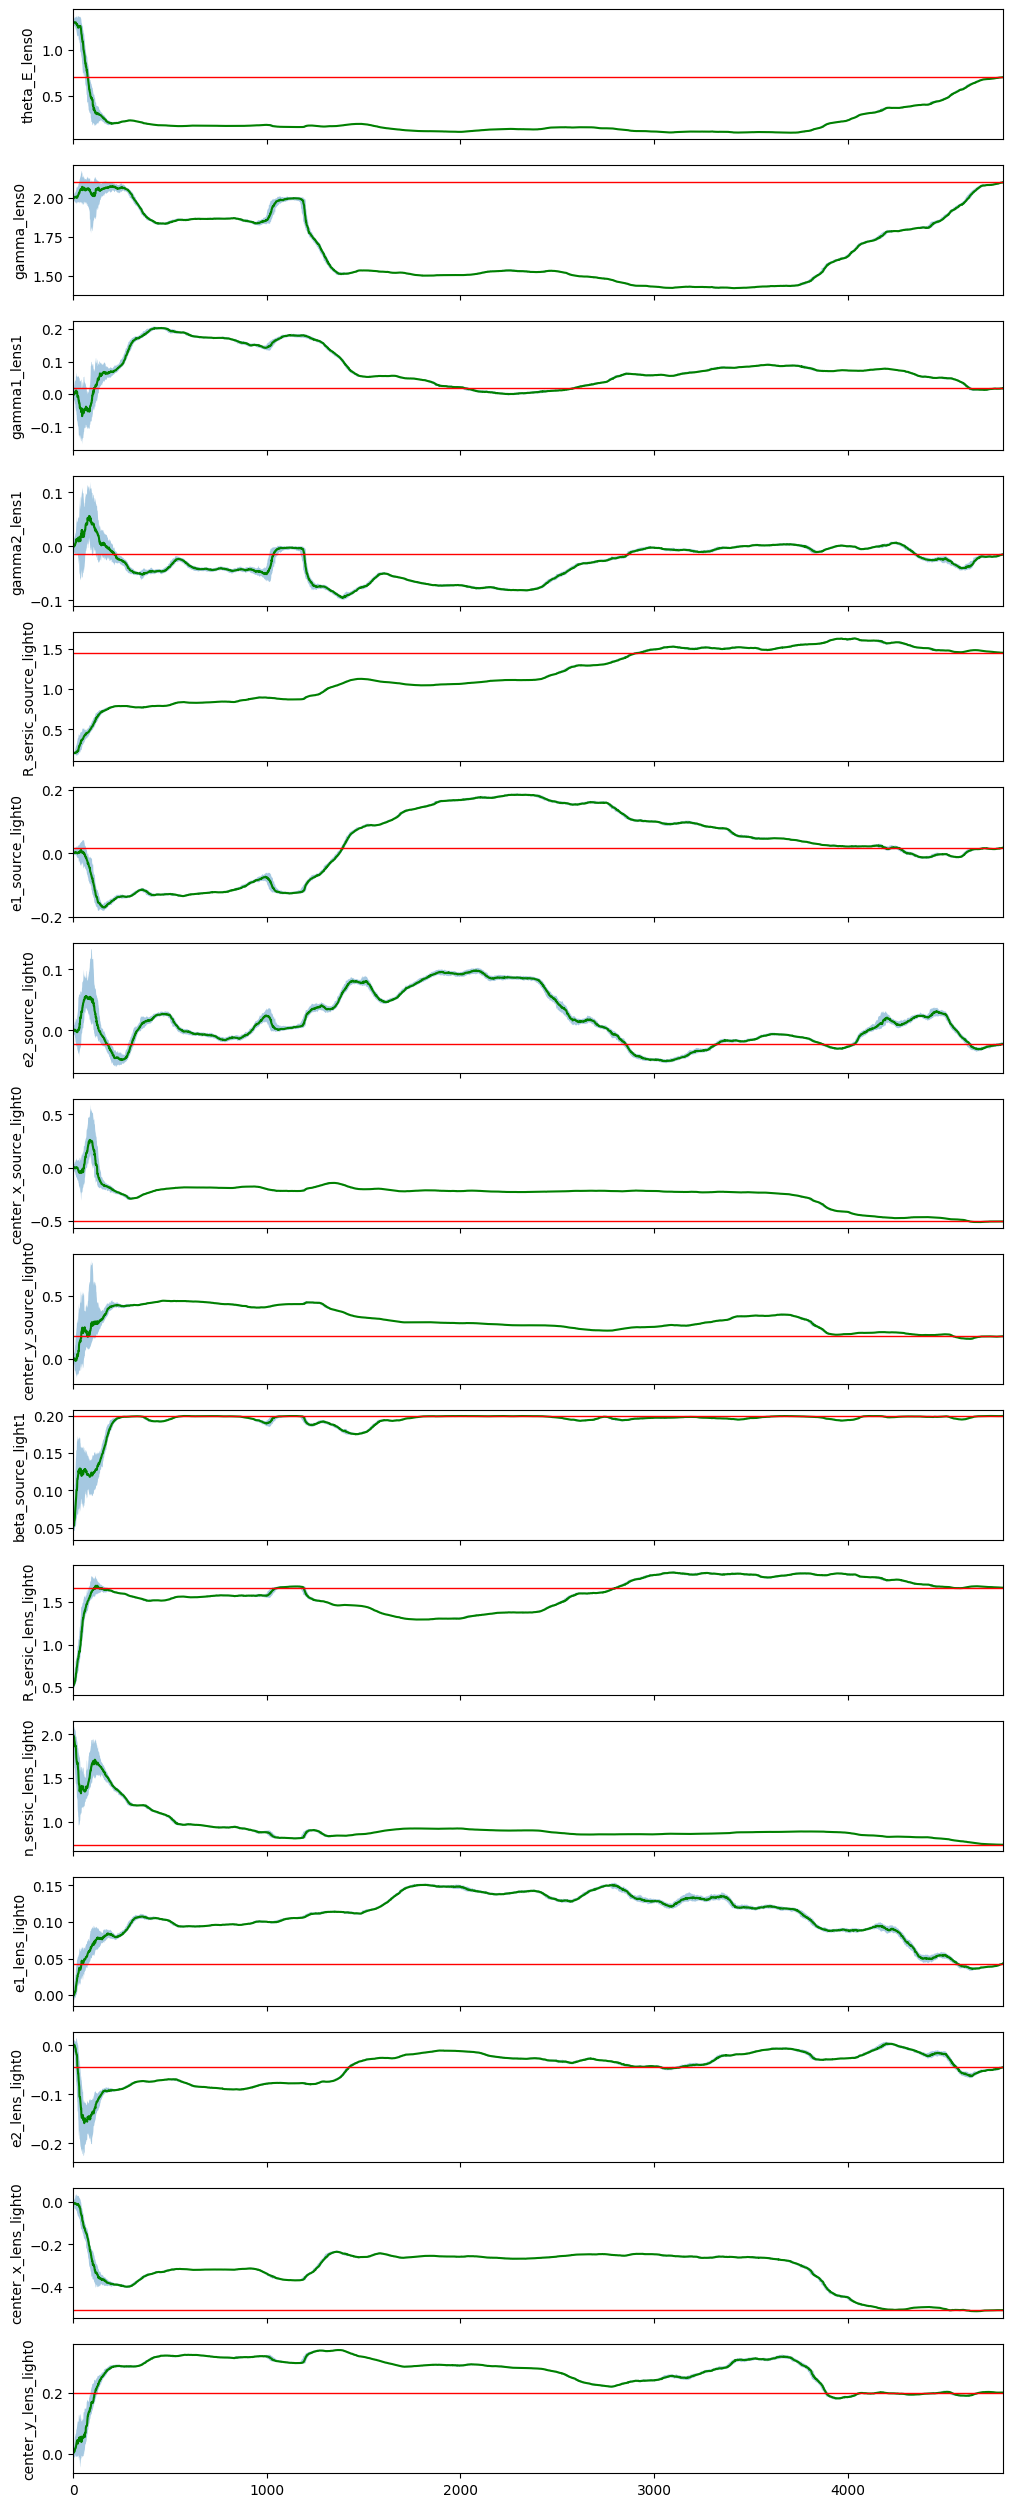

In [19]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != 'PSO':
# if MCMC chain was broken in the chunks,
# we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = 4801

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers,
                                                           n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order='F')
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last - 1],
     (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
                    median_pos[1][last - 1],
                     (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last - 1],
         (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last),
                           q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2 * len(param_mcmc)))
        plt.show()


Number of non-linear parameters in the MCMC process: 16
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Number of evaluations in the MCMC process: 384080
384080
Shape of samples_mcmc_cut: (480, 16)


<ipython-input-20-f48f61258e0a>:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


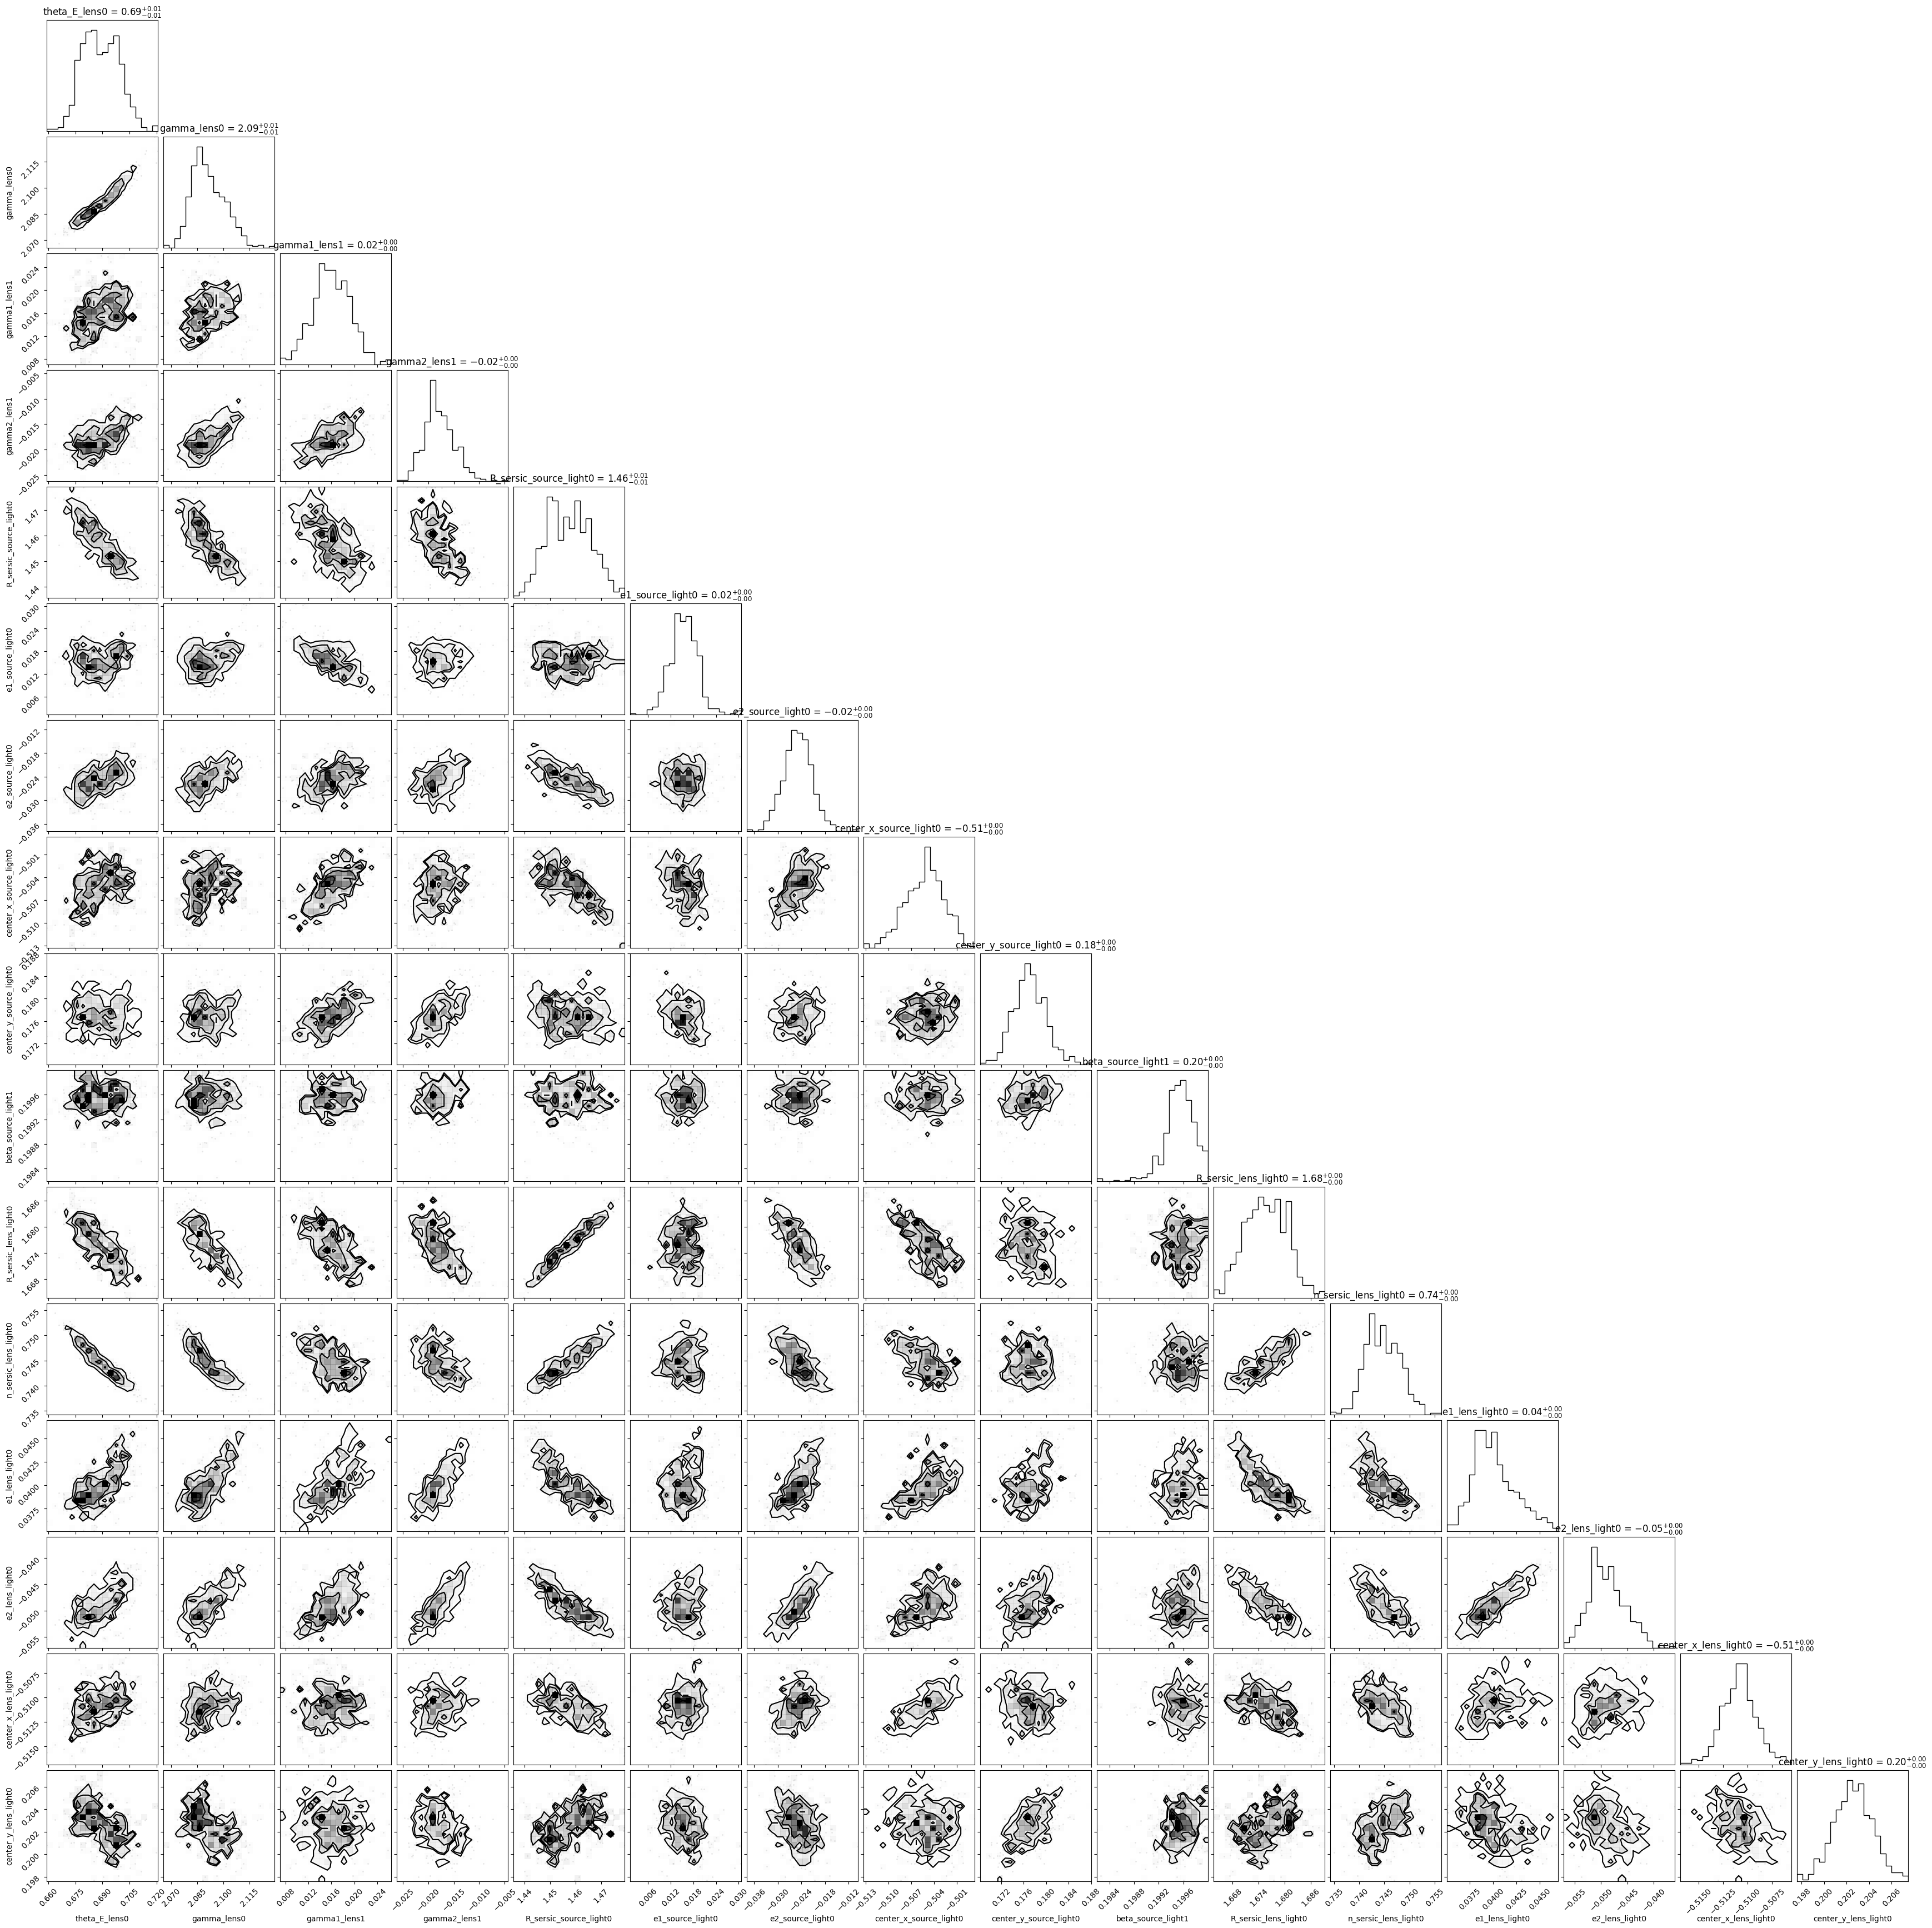

In [20]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:",
          len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:",
              np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 4700 # estimated steps where the parameters convegred
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc,
                                show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")


-4.03475325868284 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  4.03475325868272


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


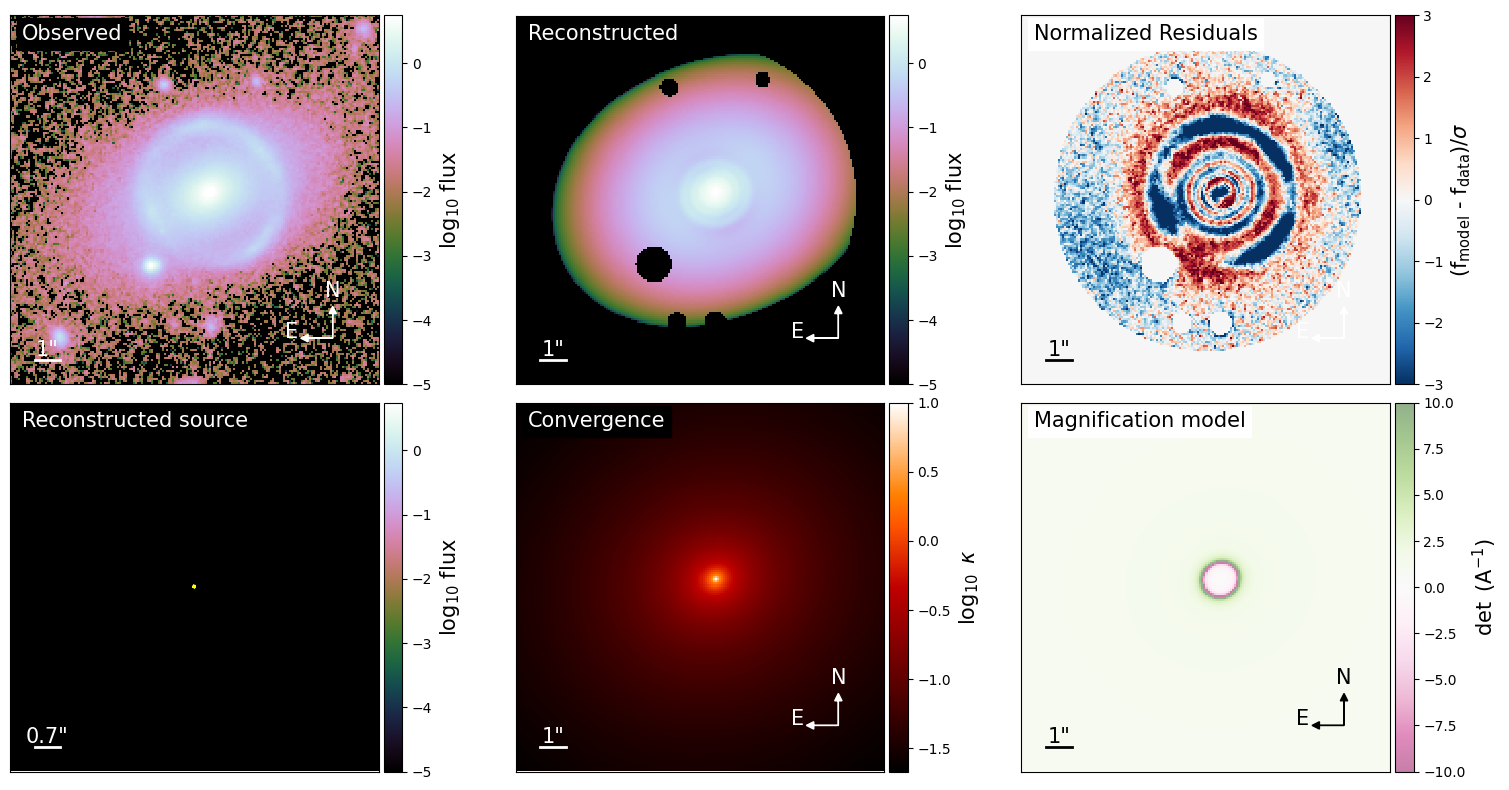

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


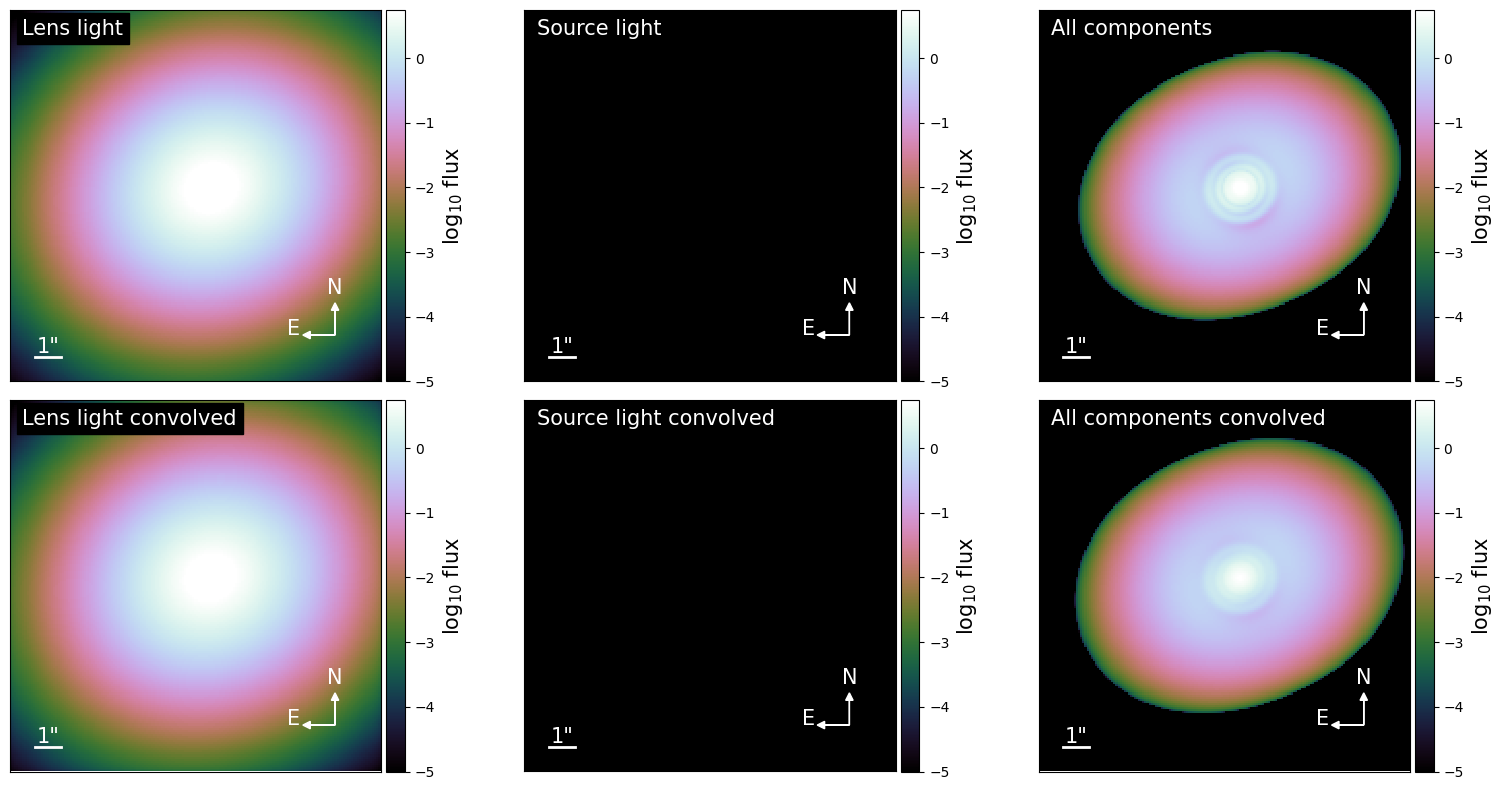

{'kwargs_lens': [{'theta_E': 0.7025328967698363, 'gamma': 2.108230584705556, 'e1': 0.04539678234383319, 'e2': -0.04731265349245673, 'center_x': -0.5118259624618601, 'center_y': 0.20119986056486158}, {'gamma1': 0.020065337167278582, 'gamma2': -0.013132037429010548, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -255.63341880511936, 'R_sersic': 1.4472222527603489, 'n_sersic': 1.0, 'e1': 0.017818160940901325, 'e2': -0.027654306177540784, 'center_x': -0.505827024852147, 'center_y': 0.1802825347930943}, {'amp': array([ 1.16058745e+03,  9.47298246e-01, -1.97189912e+01,  3.59544229e+02,
       -7.54113550e+01,  2.97384094e+02,  1.29712882e+00, -1.42615410e+01,
       -4.85190338e+00, -2.48549073e+01,  2.64865804e+02, -6.98177403e-01,
        2.02974007e+02,  1.43998528e+01,  2.57435948e+02,  5.47905177e+00,
       -1.22984178e+01,  8.48168103e+00, -2.04530823e+01,  8.09694005e+00,
       -2.19632467e+01,  1.66689725e+02, -3.93670338e+01,  1.13608266e+02,
       -3.06575402e+01,  9.8558113

In [21]:
model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"]
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.1, numPix=100,
                       with_caustics=True, scale_size=0.7)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0, 0], text='Lens light',
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 0], text='Lens light convolved',
                              lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0, 1], text='Source light',
                              source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 1], text='Source light convolved',
                              source_add=True)
model_plot.decomposition_plot(ax=axes[0, 2], text='All components',
                              source_add=True, lens_light_add=True,
                              unconvolved=True)
model_plot.decomposition_plot(ax=axes[1, 2], text='All components convolved',
                              source_add=True, lens_light_add=True,
                              point_source_add=True)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None,
                  wspace=0., hspace=0.05)
plt.show()

print(kwargs_result_mcmc)